### Modelio paruošimas mokymui

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Duomenys iš https://www.cs.toronto.edu/~kriz/cifar.html
# Keras prie jų suteikia dar palengvintą prieigą
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# X = np.concatenate((train_images,test_images))
# Y = np.concatenate((train_labels,test_labels))
# train_images, test_images, test_labels, validation_labels = train_test_split(
#     X, Y, train_size=0.8, random_state=1)

In [3]:
# Klasių pavadinimai
classes_labels = np.char.title(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])

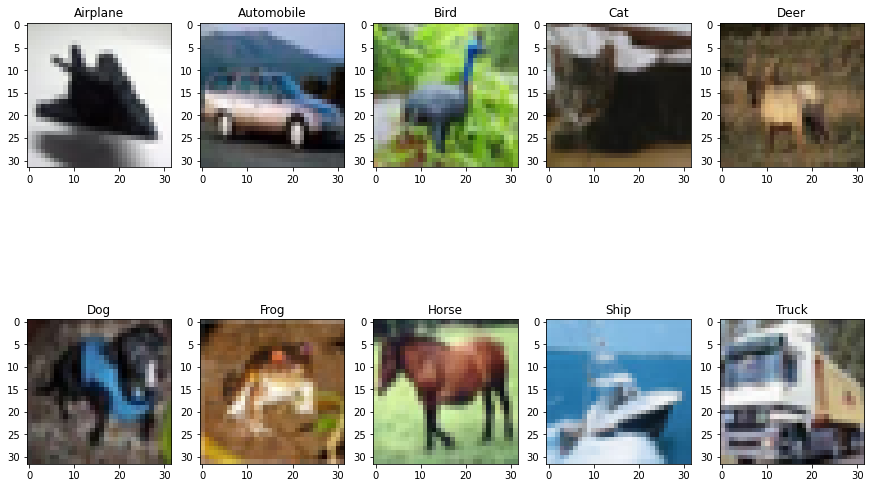

In [4]:
# Kiekvienos klasės pavyzdys
fig, ax = plt.subplots(2,5,figsize=(15, 10))
for i in range(0,10):
    indice = np.where(train_labels == i)[0][0]
    ax[i//5,i%5].imshow(train_images[indice])
    ax[i//5,i%5].set_title(classes_labels[i])

In [5]:
# modelio sudarymas
def build_model(activation):
    inputs = tf.keras.Input(shape=(32,32,3,))
      
  # x = layers.RandomFlip("horizontal")(inputs),
  # x = layers.RandomRotation(0.1),
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation=activation, input_shape=(32, 32, 3))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation=activation)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation=activation)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation=activation)(x)
    output = layers.Dense(10)(x)

    model = tf.keras.Model(inputs, output)
    
    return model

In [6]:
# sudaryto modelio pavaizdavimas
model = build_model('relu')
model.summary()
tf.keras.utils.plot_model(model, "CNN_model_structure.png")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                         

In [7]:
# modelio mokymas
def train_model(train_images,train_labels,
                activation = "relu",
                batch_size = 32,
                optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"],
                attempt = 1,model=None,epochs=10):
    
    if model is None:
        model = build_model(activation)
    
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    tensorboard_callback = tf.keras.callbacks.TensorBoard('logs', histogram_freq=1)
    modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="modeliai/" + "hyperparameter_set_" + str(attempt) + "/epoch_{epoch}",
        save_freq='epoch',
        save_best_only=True)

    history = model.fit(train_images, train_labels, epochs=epochs, 
                        validation_split=0.2, 
                        verbose = 2, batch_size = batch_size,
                        callbacks=[tensorboard_callback,modelcheckpoint_callback])
    
    return model, history

In [8]:
# modelio įvertinimas
def evaluate_model(model,history,test_images,test_labels,**kwargs):
    
    plt.plot(history.history['accuracy'], label='Mokymo duomenys')
    plt.plot(history.history['val_accuracy'], label = 'Validacijos duomenys')
    plt.xlabel('Epocha')
    plt.ylabel('Tikslumas')
    plt.legend(loc='lower right')
    plt.title(kwargs.__str__())
    plt.show()
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
    print("Modelio tikslumas: ", round(test_accuracy,2))
    
    return test_loss, test_accuracy

In [9]:
# mokymas ir įvertinimas
def pipeline(train_images,train_labels,
             test_images,test_labels,
             activation="relu",
             batch_size=32,
             optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"],
             attempt = 1,model=None,epochs=10):
    
    model, history = train_model(train_images,train_labels,
                                 activation,batch_size,
                                 optimizer,loss,metrics,attempt,model,epochs)
    _, test_accuracy = evaluate_model(model,history,test_images,test_labels,
                                      activation=activation,
                                      batch_size=batch_size,
                                     optimizer=optimizer)
    return model, history, test_accuracy

In [10]:
# hiperparametrai, kurių įtaką tikrinsiu
from sklearn.model_selection import ParameterGrid

grid = ParameterGrid({"activation":["relu","sigmoid"],"batch_size":[32,64,128],"optimizer":["sgd","adam"]})

results = pd.DataFrame(list(grid))

test_accuracies = []
models = []
histories = []

### Modelių mokymas

In [132]:
%load_ext tensorboard
%tensorboard --logdir logs

In [13]:
inputs = tf.keras.Input(shape=(32,32,3,))

x = layers.Rescaling(scale=1.0 / 255)(inputs)
x = layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(10)(x)

model1 = tf.keras.Model(inputs, output)

In [14]:
inputs = tf.keras.Input(shape=(32,32,3,))

x = layers.Rescaling(scale=1.0 / 255)(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(10)(x)

model2 = tf.keras.Model(inputs, output)

In [20]:
inputs = tf.keras.Input(shape=(32,32,3,))

x = layers.Rescaling(scale=1.0 / 255)(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(10)(x)

model3 = tf.keras.Model(inputs, output)

In [17]:
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 flatten_3 (Flatten)         (None, 5408)              0         
                                                           

In [18]:
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 flatten_4 (Flatten)         (None, 10816)             0         
                                                           

In [21]:
model3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                       

Epoch 1/20


2022-11-03 00:17:13.336967: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_99/epoch_1/assets
1250/1250 - 9s - loss: 1.9501 - accuracy: 0.2861 - val_loss: 1.7368 - val_accuracy: 0.3727 - 9s/epoch - 8ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_99/epoch_2/assets
1250/1250 - 8s - loss: 1.6042 - accuracy: 0.4228 - val_loss: 1.5074 - val_accuracy: 0.4618 - 8s/epoch - 7ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_99/epoch_3/assets
1250/1250 - 8s - loss: 1.4511 - accuracy: 0.4809 - val_loss: 1.4032 - val_accuracy: 0.5010 - 8s/epoch - 7ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_99/epoch_4/assets
1250/1250 - 8s - loss: 1.3612 - accuracy: 0.5137 - val_loss: 1.3526 - val_accuracy: 0.5205 - 8s/epoch - 7ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_99/epoch_5/assets
1250/1250 - 8s - loss: 1.2905 - accuracy: 0.5438 - val_loss: 1.2681 - val_accuracy: 0.5599 - 8s/epo

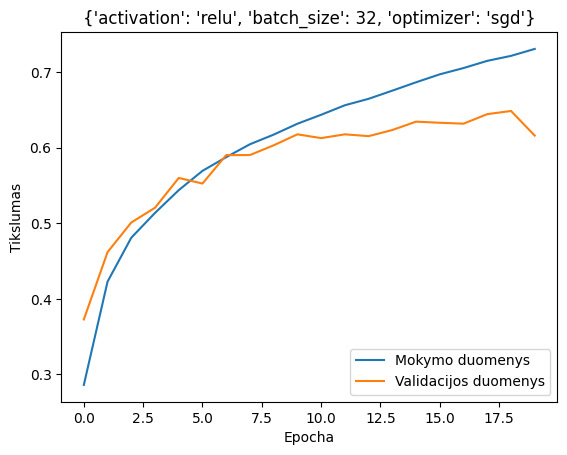

313/313 - 1s - loss: 1.2017 - accuracy: 0.5982 - 596ms/epoch - 2ms/step
Modelio tikslumas:  0.6


In [14]:
i = 99

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[0],attempt = i,model=model1,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_98/epoch_1/assets
1250/1250 - 8s - loss: 1.9624 - accuracy: 0.2918 - val_loss: 1.7517 - val_accuracy: 0.3669 - 8s/epoch - 6ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_98/epoch_2/assets
1250/1250 - 7s - loss: 1.6033 - accuracy: 0.4292 - val_loss: 1.5642 - val_accuracy: 0.4478 - 7s/epoch - 6ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_98/epoch_3/assets
1250/1250 - 7s - loss: 1.4516 - accuracy: 0.4825 - val_loss: 1.3873 - val_accuracy: 0.5059 - 7s/epoch - 6ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_98/epoch_4/assets
1250/1250 - 8s - loss: 1.3531 - accuracy: 0.5188 - val_loss: 1.3184 - val_accuracy: 0.5415 - 8s/epoch - 6ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_98/epoch_5/assets
1250/1250 - 8s - loss: 1.2800 - accuracy: 0.5492 - val_loss: 1.2767 - val_accuracy: 0.55

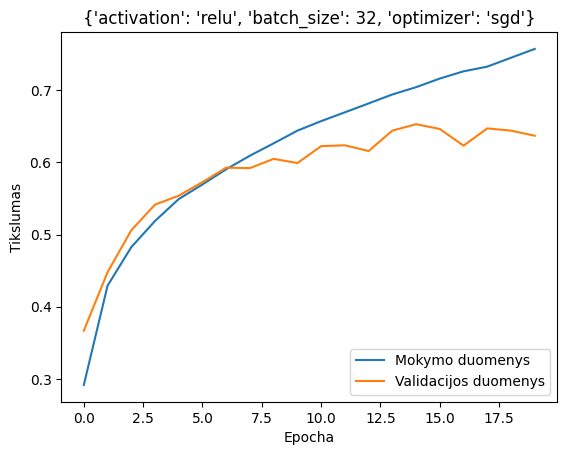

313/313 - 1s - loss: 1.1184 - accuracy: 0.6289 - 677ms/epoch - 2ms/step
Modelio tikslumas:  0.63


In [79]:
i = 98

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[0],attempt = i,model=model2,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_97/epoch_1/assets
1250/1250 - 12s - loss: 2.0808 - accuracy: 0.2394 - val_loss: 1.9490 - val_accuracy: 0.3022 - 12s/epoch - 10ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_97/epoch_2/assets
1250/1250 - 12s - loss: 1.7420 - accuracy: 0.3710 - val_loss: 1.6244 - val_accuracy: 0.4213 - 12s/epoch - 9ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_97/epoch_3/assets
1250/1250 - 12s - loss: 1.5365 - accuracy: 0.4448 - val_loss: 1.4872 - val_accuracy: 0.4602 - 12s/epoch - 9ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_97/epoch_4/assets
1250/1250 - 12s - loss: 1.4270 - accuracy: 0.4865 - val_loss: 1.4228 - val_accuracy: 0.4903 - 12s/epoch - 9ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_97/epoch_5/assets
1250/1250 - 12s - loss: 1.3480 - accuracy: 0.5177 - val_loss: 1.3830 - val_accu

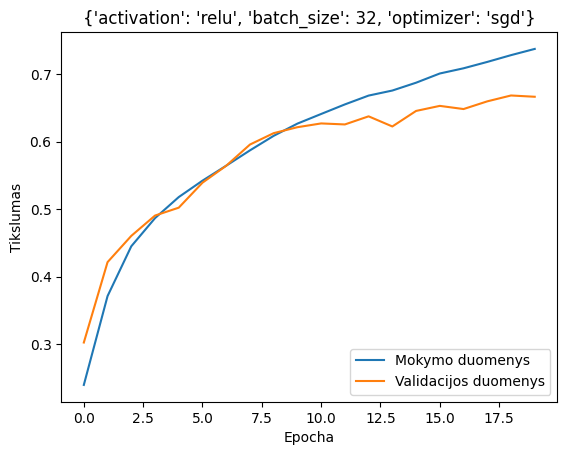

313/313 - 1s - loss: 0.9776 - accuracy: 0.6658 - 835ms/epoch - 3ms/step
Modelio tikslumas:  0.67


In [68]:
i = 97

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[0],attempt = i,model=model3,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_1/assets
1250/1250 - 13s - loss: 2.1176 - accuracy: 0.2137 - val_loss: 2.0276 - val_accuracy: 0.2572 - 13s/epoch - 10ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_2/assets
1250/1250 - 12s - loss: 1.8196 - accuracy: 0.3369 - val_loss: 1.6902 - val_accuracy: 0.3822 - 12s/epoch - 10ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_3/assets
1250/1250 - 12s - loss: 1.6099 - accuracy: 0.4152 - val_loss: 1.5134 - val_accuracy: 0.4497 - 12s/epoch - 10ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_4/assets
1250/1250 - 12s - loss: 1.4772 - accuracy: 0.4634 - val_loss: 1.4504 - val_accuracy: 0.4726 - 12s/epoch - 10ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_5/assets
1250/1250 - 12s - loss: 1.3855 - accuracy: 0.5021 - val_loss: 1.3410 - val_accura

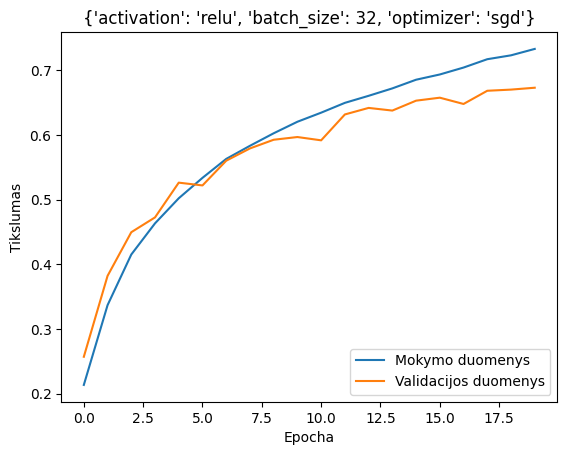

313/313 - 1s - loss: 0.9600 - accuracy: 0.6727 - 833ms/epoch - 3ms/step
Modelio tikslumas:  0.67


In [84]:
i = 0

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_1/assets
1250/1250 - 13s - loss: 1.5629 - accuracy: 0.4314 - val_loss: 1.2638 - val_accuracy: 0.5454 - 13s/epoch - 10ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_2/assets
1250/1250 - 12s - loss: 1.1935 - accuracy: 0.5773 - val_loss: 1.1324 - val_accuracy: 0.6011 - 12s/epoch - 9ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_3/assets
1250/1250 - 12s - loss: 1.0506 - accuracy: 0.6321 - val_loss: 1.0229 - val_accuracy: 0.6379 - 12s/epoch - 9ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_4/assets
1250/1250 - 12s - loss: 0.9431 - accuracy: 0.6708 - val_loss: 0.9819 - val_accuracy: 0.6550 - 12s/epoch - 10ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_5/assets
1250/1250 - 12s - loss: 0.8682 - accuracy: 0.6959 - val_loss: 0.9519 - val_accuracy

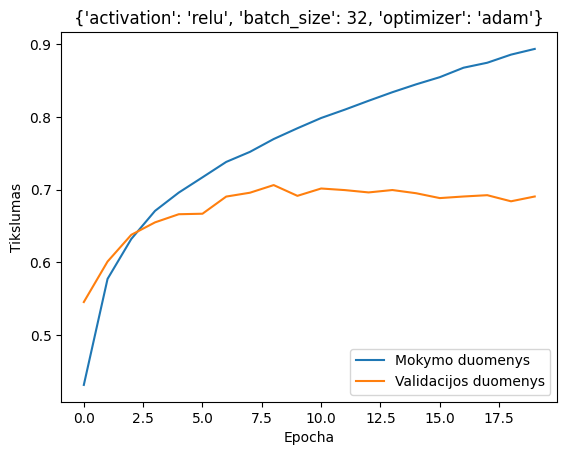

313/313 - 1s - loss: 1.3556 - accuracy: 0.6841 - 841ms/epoch - 3ms/step
Modelio tikslumas:  0.68


In [85]:
i = 1

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_1/assets
625/625 - 11s - loss: 2.1977 - accuracy: 0.1812 - val_loss: 2.0501 - val_accuracy: 0.2516 - 11s/epoch - 17ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_2/assets
625/625 - 10s - loss: 1.9443 - accuracy: 0.2972 - val_loss: 1.8331 - val_accuracy: 0.3306 - 10s/epoch - 16ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_3/assets
625/625 - 10s - loss: 1.7713 - accuracy: 0.3629 - val_loss: 1.6767 - val_accuracy: 0.4013 - 10s/epoch - 16ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_4/assets
625/625 - 10s - loss: 1.6447 - accuracy: 0.4083 - val_loss: 1.5942 - val_accuracy: 0.4327 - 10s/epoch - 16ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_5/assets
625/625 - 11s - loss: 1.5547 - accuracy: 0.4373 - val_loss: 1.4937 - val_accuracy: 0.4652

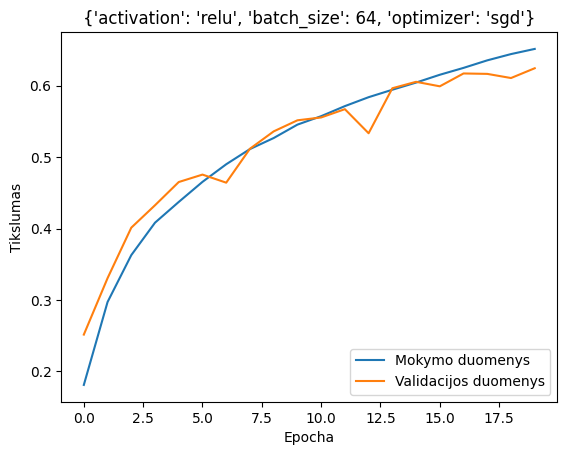

313/313 - 1s - loss: 1.0700 - accuracy: 0.6266 - 839ms/epoch - 3ms/step
Modelio tikslumas:  0.63


In [86]:
i = 2

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_1/assets
625/625 - 11s - loss: 1.6211 - accuracy: 0.4087 - val_loss: 1.3577 - val_accuracy: 0.5111 - 11s/epoch - 17ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_2/assets
625/625 - 11s - loss: 1.2593 - accuracy: 0.5510 - val_loss: 1.2343 - val_accuracy: 0.5552 - 11s/epoch - 17ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_3/assets
625/625 - 10s - loss: 1.1031 - accuracy: 0.6103 - val_loss: 1.0587 - val_accuracy: 0.6255 - 10s/epoch - 16ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_4/assets
625/625 - 10s - loss: 1.0085 - accuracy: 0.6458 - val_loss: 1.0140 - val_accuracy: 0.6438 - 10s/epoch - 16ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_5/assets
625/625 - 10s - loss: 0.9292 - accuracy: 0.6742 - val_loss: 0.9703 - val_accuracy: 0.6585

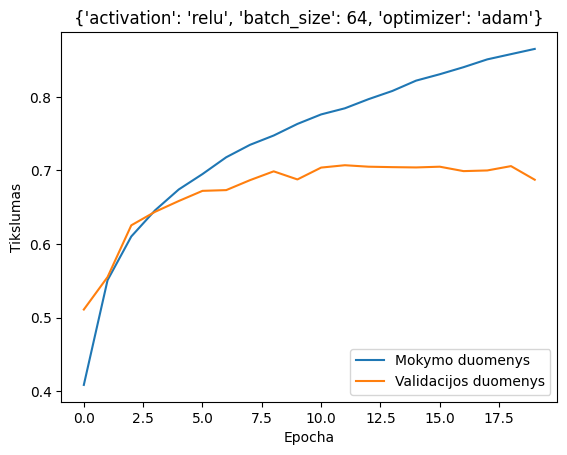

313/313 - 1s - loss: 1.1499 - accuracy: 0.6803 - 841ms/epoch - 3ms/step
Modelio tikslumas:  0.68


In [87]:
i = 3

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_1/assets
313/313 - 10s - loss: 2.2853 - accuracy: 0.1516 - val_loss: 2.2558 - val_accuracy: 0.1829 - 10s/epoch - 30ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_2/assets
313/313 - 9s - loss: 2.1704 - accuracy: 0.2131 - val_loss: 2.0519 - val_accuracy: 0.2591 - 9s/epoch - 29ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_3/assets
313/313 - 9s - loss: 2.0006 - accuracy: 0.2757 - val_loss: 1.9236 - val_accuracy: 0.3094 - 9s/epoch - 29ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_4/assets
313/313 - 9s - loss: 1.8962 - accuracy: 0.3170 - val_loss: 1.8827 - val_accuracy: 0.3312 - 9s/epoch - 29ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_5/assets
313/313 - 9s - loss: 1.8088 - accuracy: 0.3498 - val_loss: 1.7487 - val_accuracy: 0.3711 - 9s/e

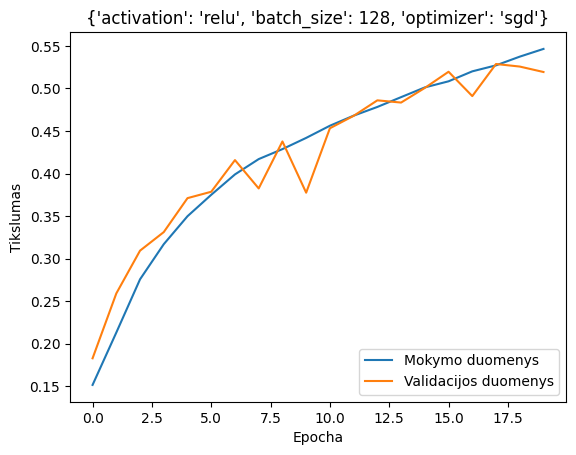

313/313 - 1s - loss: 1.3353 - accuracy: 0.5194 - 839ms/epoch - 3ms/step
Modelio tikslumas:  0.52


In [88]:
i = 4

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_1/assets
313/313 - 10s - loss: 1.7426 - accuracy: 0.3607 - val_loss: 1.4481 - val_accuracy: 0.4809 - 10s/epoch - 33ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_2/assets
313/313 - 9s - loss: 1.3532 - accuracy: 0.5146 - val_loss: 1.2897 - val_accuracy: 0.5422 - 9s/epoch - 30ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_3/assets
313/313 - 9s - loss: 1.2194 - accuracy: 0.5655 - val_loss: 1.1738 - val_accuracy: 0.5848 - 9s/epoch - 30ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_4/assets
313/313 - 9s - loss: 1.1217 - accuracy: 0.6062 - val_loss: 1.1244 - val_accuracy: 0.6020 - 9s/epoch - 30ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_5/assets
313/313 - 9s - loss: 1.0524 - accuracy: 0.6320 - val_loss: 1.0664 - val_accuracy: 0.6283 - 9s/e

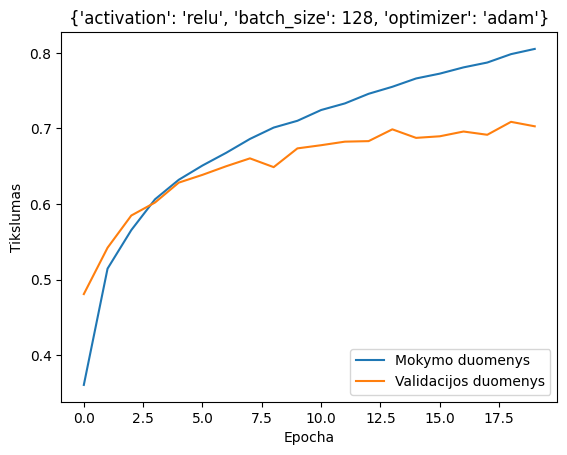

313/313 - 1s - loss: 0.9379 - accuracy: 0.6973 - 820ms/epoch - 3ms/step
Modelio tikslumas:  0.7


In [89]:
i = 5

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_6/epoch_1/assets
1250/1250 - 13s - loss: 2.3080 - accuracy: 0.0989 - val_loss: 2.3082 - val_accuracy: 0.1014 - 13s/epoch - 10ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_6/epoch_2/assets
1250/1250 - 13s - loss: 2.3052 - accuracy: 0.1024 - val_loss: 2.3076 - val_accuracy: 0.1064 - 13s/epoch - 10ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_6/epoch_3/assets
1250/1250 - 12s - loss: 2.3053 - accuracy: 0.0999 - val_loss: 2.3064 - val_accuracy: 0.0980 - 12s/epoch - 10ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_6/epoch_4/assets
1250/1250 - 12s - loss: 2.3056 - accuracy: 0.0988 - val_loss: 2.3043 - val_accuracy: 0.0980 - 12s/epoch - 10ms/step
Epoch 5/20
1250/1250 - 12s - loss: 2.3051 - accuracy: 0.1007 - val_loss: 2.3047 - val_accuracy: 0.1016 - 12s/epoch - 9ms/step
Epoch 6/20
INFO:tensorflow:Assets written to: 

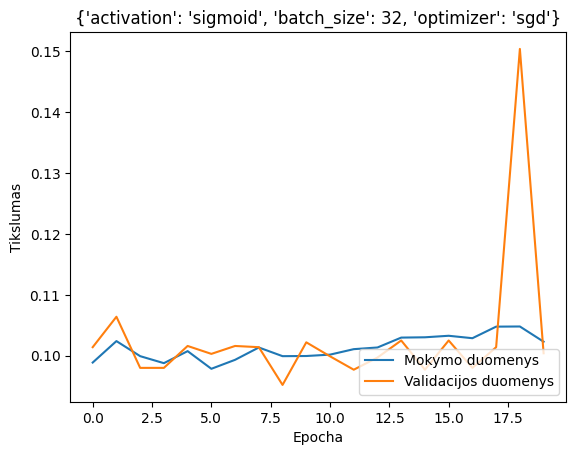

313/313 - 1s - loss: 2.3031 - accuracy: 0.1065 - 869ms/epoch - 3ms/step
Modelio tikslumas:  0.11


In [90]:
i = 6

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_1/assets
1250/1250 - 13s - loss: 2.1044 - accuracy: 0.2173 - val_loss: 1.8827 - val_accuracy: 0.3232 - 13s/epoch - 11ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_2/assets
1250/1250 - 12s - loss: 1.7267 - accuracy: 0.3796 - val_loss: 1.6301 - val_accuracy: 0.4165 - 12s/epoch - 10ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_3/assets
1250/1250 - 12s - loss: 1.5517 - accuracy: 0.4420 - val_loss: 1.5146 - val_accuracy: 0.4557 - 12s/epoch - 10ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_4/assets
1250/1250 - 12s - loss: 1.4777 - accuracy: 0.4665 - val_loss: 1.4474 - val_accuracy: 0.4785 - 12s/epoch - 10ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_5/assets
1250/1250 - 12s - loss: 1.4078 - accuracy: 0.4921 - val_loss: 1.4339 - val_accura

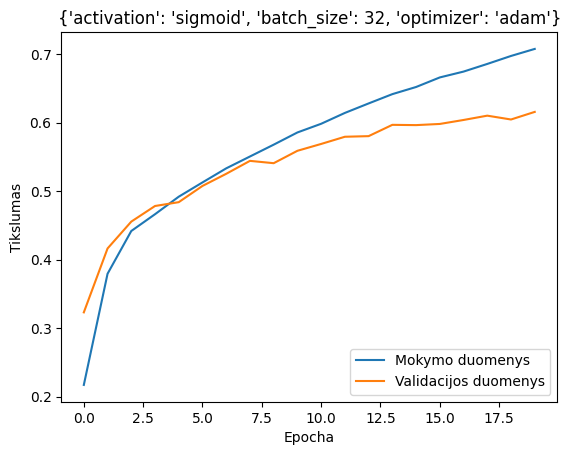

313/313 - 1s - loss: 1.1383 - accuracy: 0.6038 - 920ms/epoch - 3ms/step
Modelio tikslumas:  0.6


In [91]:
i = 7

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_8/epoch_1/assets
625/625 - 11s - loss: 2.3072 - accuracy: 0.0983 - val_loss: 2.3032 - val_accuracy: 0.1022 - 11s/epoch - 18ms/step
Epoch 2/20
625/625 - 10s - loss: 2.3041 - accuracy: 0.1009 - val_loss: 2.3061 - val_accuracy: 0.1016 - 10s/epoch - 16ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_8/epoch_3/assets
625/625 - 11s - loss: 2.3043 - accuracy: 0.1019 - val_loss: 2.3030 - val_accuracy: 0.1014 - 11s/epoch - 17ms/step
Epoch 4/20
625/625 - 10s - loss: 2.3044 - accuracy: 0.0988 - val_loss: 2.3031 - val_accuracy: 0.0997 - 10s/epoch - 16ms/step
Epoch 5/20
625/625 - 10s - loss: 2.3041 - accuracy: 0.0991 - val_loss: 2.3032 - val_accuracy: 0.0996 - 10s/epoch - 16ms/step
Epoch 6/20
625/625 - 10s - loss: 2.3041 - accuracy: 0.0988 - val_loss: 2.3049 - val_accuracy: 0.0952 - 10s/epoch - 16ms/step
Epoch 7/20
625/625 - 10s - loss: 2.3043 - accuracy: 0.0985 - val_loss: 2.3050 - val_accura

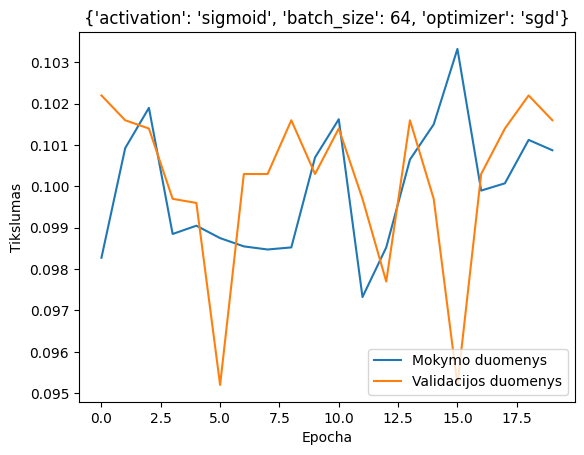

313/313 - 1s - loss: 2.3049 - accuracy: 0.1000 - 882ms/epoch - 3ms/step
Modelio tikslumas:  0.1


In [92]:
i = 8

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_1/assets
625/625 - 11s - loss: 2.1179 - accuracy: 0.2057 - val_loss: 1.9450 - val_accuracy: 0.2931 - 11s/epoch - 17ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_2/assets
625/625 - 10s - loss: 1.8555 - accuracy: 0.3232 - val_loss: 1.8101 - val_accuracy: 0.3419 - 10s/epoch - 16ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_3/assets
625/625 - 11s - loss: 1.7243 - accuracy: 0.3783 - val_loss: 1.6845 - val_accuracy: 0.3959 - 11s/epoch - 17ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_4/assets
625/625 - 10s - loss: 1.6144 - accuracy: 0.4201 - val_loss: 1.5866 - val_accuracy: 0.4270 - 10s/epoch - 16ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_5/assets
625/625 - 10s - loss: 1.5414 - accuracy: 0.4470 - val_loss: 1.5597 - val_accuracy: 0.4293

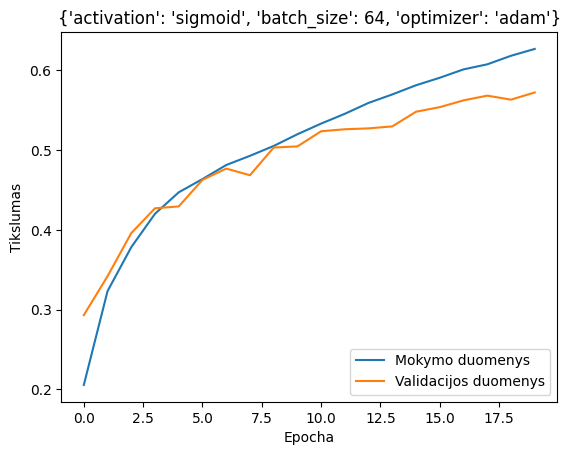

313/313 - 1s - loss: 1.2032 - accuracy: 0.5723 - 837ms/epoch - 3ms/step
Modelio tikslumas:  0.57


In [93]:
i = 9

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_10/epoch_1/assets
313/313 - 9s - loss: 2.3120 - accuracy: 0.1006 - val_loss: 2.3031 - val_accuracy: 0.1003 - 9s/epoch - 30ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_10/epoch_2/assets
313/313 - 9s - loss: 2.3034 - accuracy: 0.0979 - val_loss: 2.3030 - val_accuracy: 0.0980 - 9s/epoch - 28ms/step
Epoch 3/20
313/313 - 8s - loss: 2.3033 - accuracy: 0.0983 - val_loss: 2.3036 - val_accuracy: 0.0977 - 8s/epoch - 26ms/step
Epoch 4/20
313/313 - 8s - loss: 2.3034 - accuracy: 0.0981 - val_loss: 2.3035 - val_accuracy: 0.1003 - 8s/epoch - 26ms/step
Epoch 5/20
313/313 - 8s - loss: 2.3033 - accuracy: 0.1010 - val_loss: 2.3039 - val_accuracy: 0.0980 - 8s/epoch - 26ms/step
Epoch 6/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_10/epoch_6/assets
313/313 - 9s - loss: 2.3034 - accuracy: 0.0995 - val_loss: 2.3027 - val_accuracy: 0.0977 - 9s/epoch - 28ms/step
Epoch 7/20
313/313 

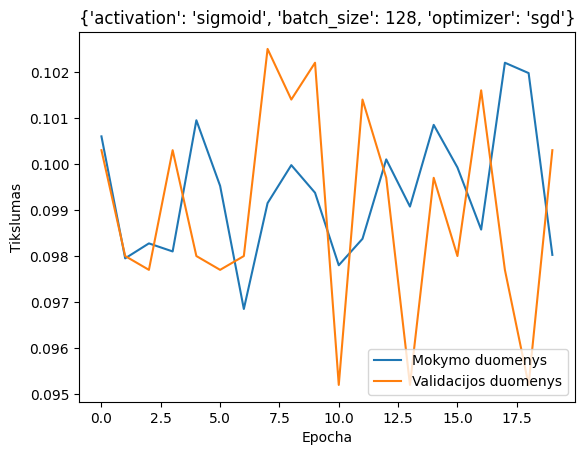

313/313 - 1s - loss: 2.3031 - accuracy: 0.1000 - 771ms/epoch - 2ms/step
Modelio tikslumas:  0.1


In [94]:
i = 10

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_1/assets
313/313 - 9s - loss: 2.2539 - accuracy: 0.1339 - val_loss: 2.0523 - val_accuracy: 0.2508 - 9s/epoch - 28ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_2/assets
313/313 - 8s - loss: 1.9767 - accuracy: 0.2795 - val_loss: 1.9137 - val_accuracy: 0.3033 - 8s/epoch - 27ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_3/assets
313/313 - 8s - loss: 1.8246 - accuracy: 0.3410 - val_loss: 1.7634 - val_accuracy: 0.3595 - 8s/epoch - 26ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_4/assets
313/313 - 8s - loss: 1.6772 - accuracy: 0.3999 - val_loss: 1.6727 - val_accuracy: 0.4062 - 8s/epoch - 26ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_5/assets
313/313 - 8s - loss: 1.5910 - accuracy: 0.4288 - val_loss: 1.5694 - val_accuracy: 0.4380 - 8

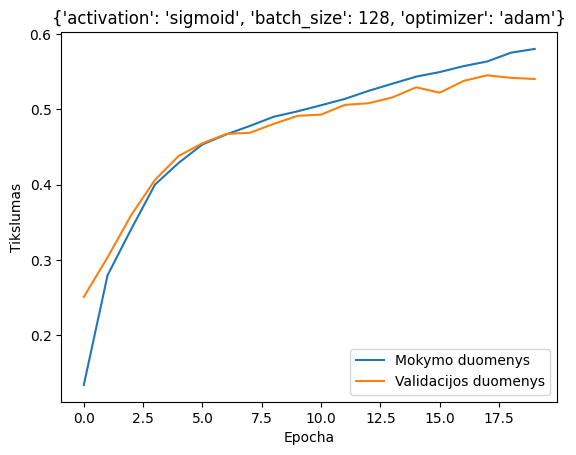

313/313 - 1s - loss: 1.2707 - accuracy: 0.5438 - 798ms/epoch - 3ms/step
Modelio tikslumas:  0.54


In [95]:
i = 11

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i,epochs=20)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

### Geriausio modelio parinkimas

In [96]:
results["test_accuracies"] = np.round_(test_accuracies,2)
results

,activation,batch_size,optimizer,test_accuracies
0,relu,32,sgd,0.67
1,relu,32,adam,0.68
2,relu,64,sgd,0.63
3,relu,64,adam,0.68
4,relu,128,sgd,0.52
5,relu,128,adam,0.70
6,sigmoid,32,sgd,0.11
7,sigmoid,32,adam,0.60
8,sigmoid,64,sgd,0.10
9,sigmoid,64,adam,0.57


In [98]:
model = models[np.argmax(test_accuracies)]
# Geriausias sudarytas modelis išsaugomas
model.save("modeliai/geriausias")
best_model = tf.keras.models.load_model("modeliai/geriausias")

INFO:tensorflow:Assets written to: modeliai/geriausias/assets


In [99]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = best_model.predict(test_images)
y_pred = [np.argmax(i) for i in y_pred]
confusion_matrix = confusion_matrix(test_labels, y_pred)
print(confusion_matrix)

test_accuracy = accuracy_score(test_labels, y_pred)
print("Geriausio modelio tikslumas: ", round(test_accuracy,2))

[[713  23  68  14  47  13  17  24  53  28]
 [ 24 822   6   9   5   8  12   6  19  89]
 [ 55   5 495  51 155  89  79  50  13   8]
 [ 15  14  45 452  85 207 102  51  14  15]
 [ 15   4  31  40 721  45  52  78  10   4]
 [ 13   1  30 121  64 668  31  59   5   8]
 [  6   6  36  38  62  33 810   7   1   1]
 [ 12   4  21  25  84  61   9 770   1  13]
 [ 88  52  17  21  11  13  15   4 746  33]
 [ 43  91  10  11   9   8  12  21  19 776]]
Geriausio modelio tikslumas:  0.7


In [103]:
from sklearn.metrics import classification_report

# greitas būdas pažiūrėti kaip gerai klasifikuojama kiekviena klasė
results_frame = pd.DataFrame(classification_report(test_labels,y_pred,output_dict=True))
results_frame.columns = np.concatenate((classes_labels,results_frame.columns[10:].values))
results_frame

,Airplane,Automobile,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck,accuracy,macro avg,weighted avg
precision,0.703774,0.821074,0.594872,0.498165,0.619857,0.641488,0.792291,0.795759,0.781369,0.800407,0.7018,0.704906,0.704906
recall,0.746000,0.826000,0.580000,0.543000,0.693000,0.569000,0.740000,0.713000,0.822000,0.786000,0.7018,0.701800,0.701800
f1-score,0.724272,0.823529,0.587342,0.519617,0.654391,0.603074,0.765253,0.752110,0.801170,0.793138,0.7018,0.702390,0.702390
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.7018,10000.000000,10000.000000


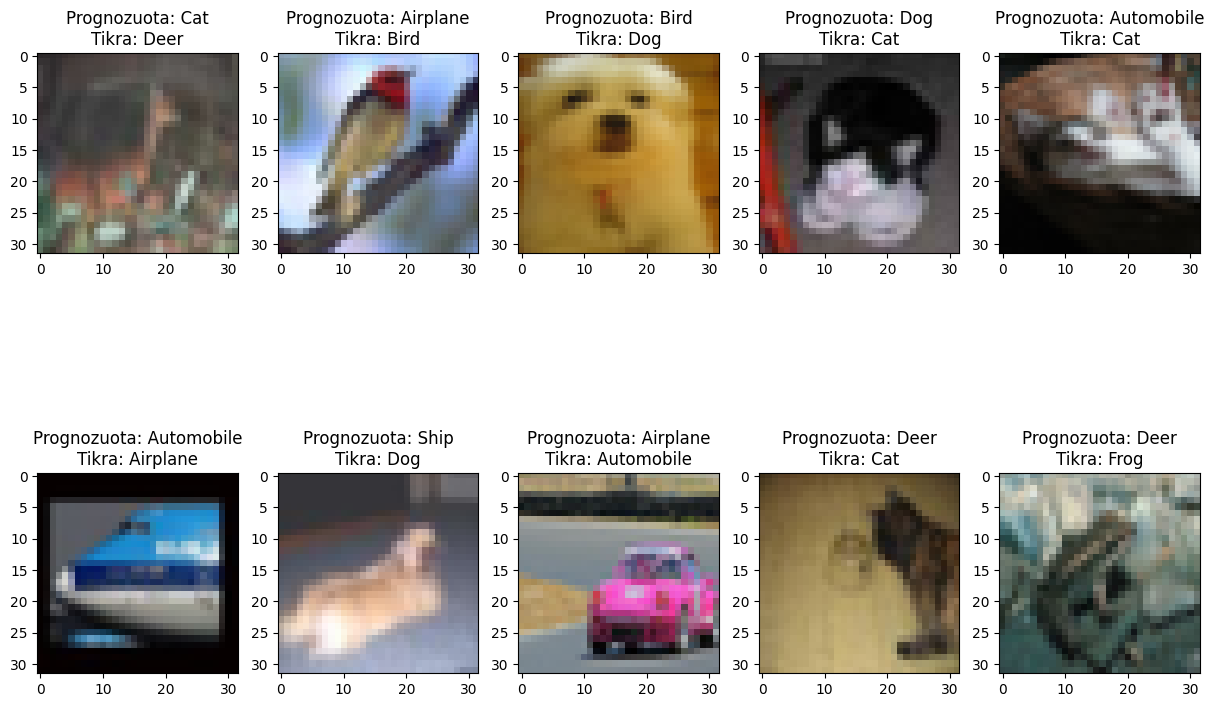

In [147]:
# Kelių neteisingų prognozių pavyzdžiai
wrong_indices = np.random.choice(np.where(y_pred != test_labels[:,0])[0],10)
fig, ax = plt.subplots(2,5,figsize=(15, 10))
for i in range(0,10):
    indice = wrong_indices[i]
    ax[i//5,i%5].imshow(test_images[indice])
    ax[i//5,i%5].set_title("Prognozuota: " + classes_labels[y_pred[indice]] +
                           "\n" + 
                           "Tikra: " + classes_labels[test_labels[indice][0]]) 

In [158]:
print("Keli atsitiktiniai stebėjimai iš testavimo aibės:")
tikra = []
prognozuota = []
teisinga = []
indices = np.random.choice(np.where(np.array(y_pred) == np.array(y_pred))[0],30)
for i in indices:
    teisinga.append(y_pred[i] == test_labels[i][0]),
    prognozuota.append(classes_labels[y_pred[i]]),
    tikra.append(classes_labels[test_labels[i][0]])
    
pd.DataFrame({"Teisinga":teisinga,"Tikra":tikra,"Prognozuota":prognozuota})

Keli atsitiktiniai stebėjimai iš testavimo aibės:


,Teisinga,Tikra,Prognozuota
0,True,Dog,Dog
1,True,Horse,Horse
2,True,Cat,Cat
3,True,Ship,Ship
4,False,Cat,Bird
5,True,Ship,Ship
6,True,Truck,Truck
7,True,Deer,Deer
8,True,Truck,Truck
9,True,Ship,Ship
